## Preprocesamiento

## Importación de librerías

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from tensorflow.keras import Input

## Configuración de parámetros

In [14]:
img_size = (48, 48)
batch_size = 32
train_dir = './EmocionesData/train'
test_dir = './EmocionesData/test'

## Verificación de integridad de datos

In [15]:
def verificar_imagenes(directorio):
    errores = []
    total = 0
    for root, _, files in os.walk(directorio):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                total += 1
                path = os.path.join(root, file)
                img = cv2.imread(path)
                if img is None:
                    errores.append(path)
    print(f"Total de imágenes revisadas: {total}")
    print(f"Imágenes corruptas: {len(errores)}")
    if errores:
        print("Rutas con error:", errores[:10])
    else:
        print("No se detectaron imágenes corruptas.")

verificar_imagenes(train_dir)

Total de imágenes revisadas: 28709
Imágenes corruptas: 0
No se detectaron imágenes corruptas.


## Análisis de distribución de clases

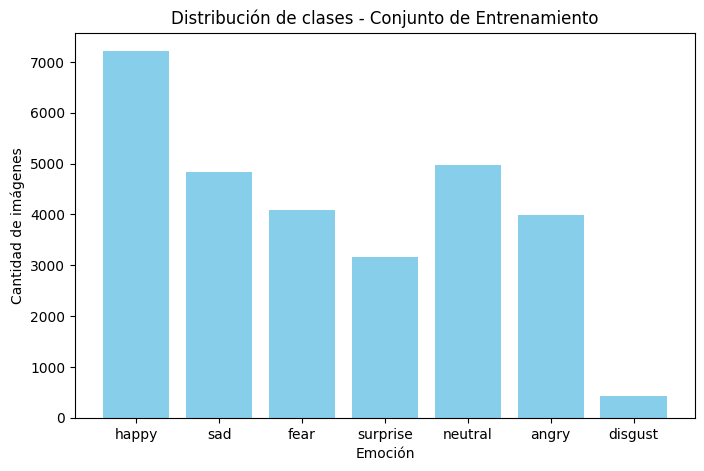

Distribución de entrenamiento: {'happy': 7215, 'sad': 4830, 'fear': 4097, 'surprise': 3171, 'neutral': 4965, 'angry': 3995, 'disgust': 436}
Distribución de prueba: {'happy': 1774, 'sad': 1247, 'fear': 1024, 'surprise': 831, 'neutral': 1233, 'angry': 958, 'disgust': 111}


In [16]:
def contar_clases(directorio):
    conteo = {}
    for clase in os.listdir(directorio):
        ruta_clase = os.path.join(directorio, clase)
        if os.path.isdir(ruta_clase):
            conteo[clase] = len(os.listdir(ruta_clase))
    return conteo

conteo_train = contar_clases(train_dir)
conteo_test = contar_clases(test_dir)

# Graficar la distribución
plt.figure(figsize=(8,5))
plt.bar(conteo_train.keys(), conteo_train.values(), color='skyblue')
plt.title('Distribución de clases - Conjunto de Entrenamiento')
plt.xlabel('Emoción')
plt.ylabel('Cantidad de imágenes')
plt.show()

print("Distribución de entrenamiento:", conteo_train)
print("Distribución de prueba:", conteo_test)

## Ejemplos visuales de imágenes

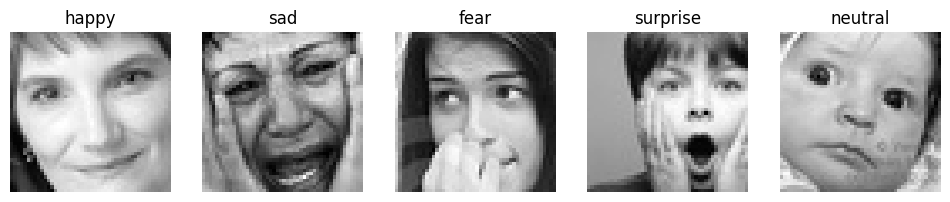

In [17]:
def mostrar_ejemplos(directorio, clases, n=5):
    plt.figure(figsize=(12, 6))
    for i, clase in enumerate(clases[:n]):
        ruta = os.path.join(directorio, clase)
        img_path = os.path.join(ruta, os.listdir(ruta)[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(clase)
        plt.axis('off')
    plt.show()

mostrar_ejemplos(train_dir, list(conteo_train.keys()))

## Generadores de imágenes con aumento de datos (Data Augmentation)

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],   # cambio de brillo para simular variaciones
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Definición del modelo CNN

In [22]:
model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para controlar sobreajuste
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mejor_modelo_emociones.keras', save_best_only=True)
]


## Entrenamiento del modelo con 30 epochs

In [23]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/30


/Users/espinozaje/PyCharmMiscProject/.venv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2429 - loss: 1.8138 - val_accuracy: 0.2537 - val_loss: 1.7729
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2598 - loss: 1.7803 - val_accuracy: 0.2947 - val_loss: 1.7423
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2817 - loss: 1.7472 - val_accuracy: 0.3396 - val_loss: 1.6372
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3113 - loss: 1.6995 - val_accuracy: 0.3757 - val_loss: 1.5783
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3527 - loss: 1.6259 - val_accuracy: 0.4133 - val_loss: 1.5108
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3869 - loss: 1.5638 - val_accuracy: 0.4652 - val_loss: 1.4085
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4027 - loss: 1.5247 - val_accuracy: 0.4833 - val_loss: 1.3598
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4222 - loss: 1.4980 - val_accurac

## Evaluación y guardado del modelo

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

model.save('modelo_emociones_final.keras')
print("Modelo final guardado correctamente.")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5655 - loss: 1.1473
Precisión en el conjunto de prueba: 0.5655
Modelo final guardado correctamente.


Mi red neuronal convolucional (CNN) está clasificando correctamente las emociones en un 56.55 % de los casos del conjunto de prueba.
El loss (1.1473) indica que el modelo aún comete errores, pero es un punto de partida sólido considerando que FER-2013 es difícil, con rostros en condiciones de iluminación, edad y ángulo variables.

Se puede mejorar la precisión de las siguientes maneras: Tomando en cuenta para la segunda parte:
- Aumentar Data Augmentation.
- Usar más capas convolucionales o BatchNormalization.
- Como punto opcional se puede aplicar Transfer Learning
- Balancear clases